# TC1 - Problema de Atribuição de Tarefas

**Objetivos:** Minimizar custo total (f_C) e desequilíbrio de carga (f_E)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

## 1. Carregamento de Dados

In [2]:
data_dir = Path('..')

m = pd.read_csv(data_dir / 'data_5x50_m.csv', header=None).values[0, 0]
n = pd.read_csv(data_dir / 'data_5x50_n.csv', header=None).values[0, 0]
a = pd.read_csv(data_dir / 'data_5x50_a.csv', header=None).values
c = pd.read_csv(data_dir / 'data_5x50_c.csv', header=None).values
b = pd.read_csv(data_dir / 'data_5x50_b.csv', header=None).values.flatten()

print(f"Dimensões: m={m}, n={n}")
print(f"Capacidades: {b}")

Dimensões: m=5, n=50
Capacidades: [106.4  126.4  127.04 115.52 112.8 ]


## 2. Verificação de Viabilidade

In [3]:
capacidade_total = b.sum()
demanda_minima = a.min(axis=0).sum()

print(f"Capacidade total: {capacidade_total:.2f}")
print(f"Demanda mínima: {demanda_minima:.2f}")
print(f"Folga: {capacidade_total - demanda_minima:.2f} ({(capacidade_total - demanda_minima)/capacidade_total*100:.1f}%)")
print(f"Status: {'✅ VIÁVEL' if capacidade_total >= demanda_minima else '❌ INVIÁVEL'}")

Capacidade total: 588.16
Demanda mínima: 409.00
Folga: 179.16 (30.5%)
Status: ✅ VIÁVEL


## 3. Funções de Cálculo

In [4]:
def calcular_custo_total(x, c):
    """Custo total: f_C = ΣΣ c_ij × x_ij"""
    return np.sum(c * x)

def calcular_cargas(x, a):
    """Carga por agente: L_i = Σ_j a_ij × x_ij"""
    return np.sum(a * x, axis=1)

def calcular_desequilibrio(x, a):
    """Desequilíbrio: f_E = L_max - L_min"""
    cargas = calcular_cargas(x, a)
    return cargas.max() - cargas.min()

def verificar_restricoes(x, a, b, verbose=True):
    """Verifica se solução x satisfaz todas as restrições"""
    viavel = True
    
    if not np.all(np.isin(x, [0, 1])):
        if verbose: print("❌ x não é binário")
        viavel = False
    
    cargas = calcular_cargas(x, a)
    for i in range(len(b)):
        if cargas[i] > b[i] + 1e-6:
            if verbose: print(f"❌ Agente {i}: carga {cargas[i]:.2f} > capacidade {b[i]:.2f}")
            viavel = False
    
    tarefas_alocadas = x.sum(axis=0)
    for j in range(x.shape[1]):
        if abs(tarefas_alocadas[j] - 1.0) > 1e-6:
            if verbose: print(f"❌ Tarefa {j} alocada {tarefas_alocadas[j]:.0f} vezes")
            viavel = False
    
    if viavel and verbose:
        print("✅ Todas as restrições satisfeitas")
    
    return viavel

## 4. Limites Teóricos

In [5]:
f_C_utopico = c.min(axis=0).sum()
f_E_utopico = 0.0
f_C_antiutopico = c.max(axis=0).sum()
f_E_antiutopico = b.max()

print(f"Ponto Utópico: f_C={f_C_utopico:.0f}, f_E={f_E_utopico:.0f}")
print(f"Ponto Anti-Utópico: f_C={f_C_antiutopico:.0f}, f_E={f_E_antiutopico:.2f}")

Ponto Utópico: f_C=855, f_E=0
Ponto Anti-Utópico: f_C=2115, f_E=127.04


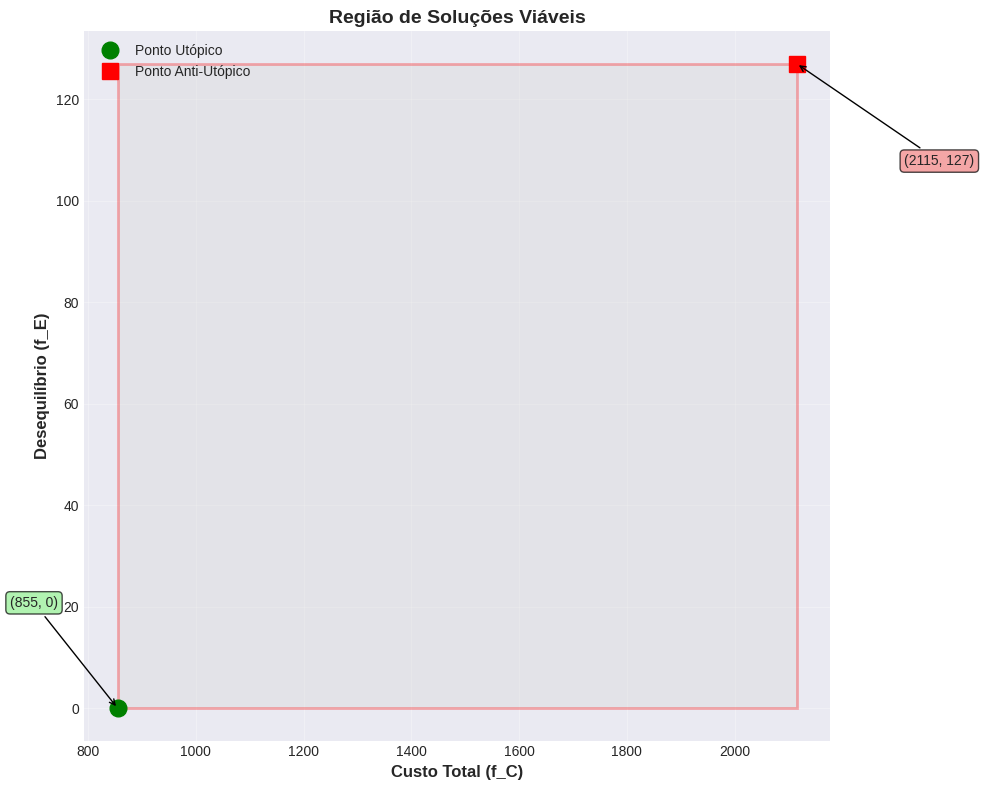

In [6]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(10, 8))

rect = Rectangle((f_C_utopico, f_E_utopico), 
                 f_C_antiutopico - f_C_utopico, 
                 f_E_antiutopico - f_E_utopico,
                 linewidth=2, edgecolor='red', facecolor='lightgray', alpha=0.3)
ax.add_patch(rect)

ax.plot(f_C_utopico, f_E_utopico, 'go', markersize=12, label='Ponto Utópico')
ax.plot(f_C_antiutopico, f_E_antiutopico, 'rs', markersize=12, label='Ponto Anti-Utópico')

ax.annotate(f'({f_C_utopico:.0f}, {f_E_utopico:.0f})',
            xy=(f_C_utopico, f_E_utopico), xytext=(f_C_utopico-200, f_E_utopico+20),
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
            arrowprops=dict(arrowstyle='->'))

ax.annotate(f'({f_C_antiutopico:.0f}, {f_E_antiutopico:.0f})',
            xy=(f_C_antiutopico, f_E_antiutopico), xytext=(f_C_antiutopico+200, f_E_antiutopico-20),
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
            arrowprops=dict(arrowstyle='->'))

ax.set_xlabel('Custo Total (f_C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Desequilíbrio (f_E)', fontsize=12, fontweight='bold')
ax.set_title('Região de Soluções Viáveis', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Otimização MILP

In [7]:
import sys
sys.path.append('..')
from otimizacao_utils import criar_modelo_milp, resolver_milp, metodo_epsilon_restrito, calcular_delta, calcular_hipervolume_2d
from pyomo.opt import SolverFactory

solver = SolverFactory('glpk')
solver_name = 'glpk' if solver.available() else None
print(f"Solver: {solver_name}")

Solver: glpk


### 5.1 Resolver Extremos

In [8]:
modelo_custo = criar_modelo_milp(m, n, a, c, b, objetivo='custo')
sol_custo = resolver_milp(modelo_custo, a, c, solver_name=solver_name)

modelo_eq = criar_modelo_milp(m, n, a, c, b, objetivo='equilibrio')
sol_eq = resolver_milp(modelo_eq, a, c, solver_name=solver_name)

print(f"Min Custo: f_C={sol_custo['f_C']:.2f}, f_E={sol_custo['f_E']:.2f}")
print(f"Min Desequilíbrio: f_C={sol_eq['f_C']:.2f}, f_E={sol_eq['f_E']:.2f}")

Min Custo: f_C=888.00, f_E=17.00
Min Desequilíbrio: f_C=1329.00, f_E=0.00


### 5.2 Método ε-Restrito

In [12]:
fronteira = metodo_epsilon_restrito(m, n, a, c, b, sol_eq['f_E'], sol_custo['f_E'], 
                                     num_pontos=30, solver_name=solver_name, verbose=False)

df_fronteira = pd.DataFrame([{'epsilon': s['epsilon'], 'f_C': s['f_C'], 'f_E': s['f_E']} for s in fronteira])
print(df_fronteira.to_string(index=False))

df_fronteira.to_csv(data_dir / 'resultados_fronteira_pareto.csv', index=False)

Gerando Fronteira de Pareto: 100%|██████████| 30/30 [25:10<00:00, 50.34s/ponto]  

  epsilon   f_C  f_E
 2.344828 923.0  2.0
 2.931034 923.0  2.0
 3.517241 909.0  3.0
 4.103448 909.0  3.0
 4.689655 909.0  3.0
 5.275862 909.0  3.0
 5.862069 909.0  3.0
 6.448276 906.0  6.0
 7.034483 903.0  7.0
 7.620690 903.0  7.0
 8.206897 902.0  8.0
 8.793103 902.0  8.0
 9.379310 902.0  8.0
 9.965517 902.0  8.0
10.551724 901.0 10.0
11.137931 901.0 10.0
11.724138 901.0 10.0
12.310345 899.0 12.0
12.896552 899.0 12.0
13.482759 899.0 12.0
14.068966 895.0 14.0
14.655172 895.0 14.0
15.241379 895.0 14.0
15.827586 895.0 14.0
16.413793 895.0 14.0
17.000000 888.0 17.0


## 6. Visualização da Fronteira

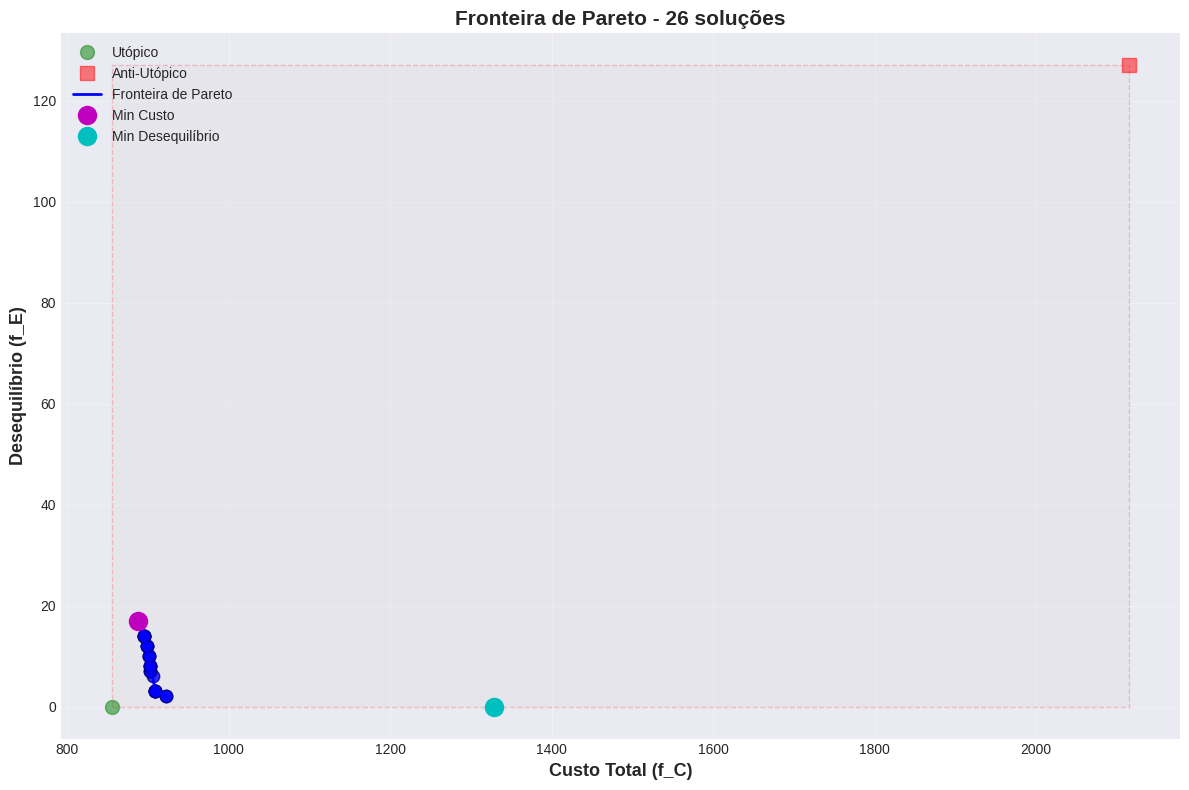

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

rect = Rectangle((f_C_utopico, f_E_utopico), f_C_antiutopico - f_C_utopico, 
                 f_E_antiutopico - f_E_utopico, linewidth=1, edgecolor='red', 
                 facecolor='lightgray', alpha=0.2, linestyle='--')
ax.add_patch(rect)

ax.plot(f_C_utopico, f_E_utopico, 'go', markersize=10, label='Utópico', alpha=0.5)
ax.plot(f_C_antiutopico, f_E_antiutopico, 'rs', markersize=10, label='Anti-Utópico', alpha=0.5)

ax.plot(df_fronteira['f_C'], df_fronteira['f_E'], 'b-', linewidth=2, label='Fronteira de Pareto')
ax.scatter(df_fronteira['f_C'], df_fronteira['f_E'], c='blue', s=80, edgecolors='darkblue', alpha=0.8)

ax.plot(sol_custo['f_C'], sol_custo['f_E'], 'mo', markersize=12, label='Min Custo', markeredgewidth=2)
ax.plot(sol_eq['f_C'], sol_eq['f_E'], 'co', markersize=12, label='Min Desequilíbrio', markeredgewidth=2)

ax.set_xlabel('Custo Total (f_C)', fontsize=13, fontweight='bold')
ax.set_ylabel('Desequilíbrio (f_E)', fontsize=13, fontweight='bold')
ax.set_title(f'Fronteira de Pareto - {len(df_fronteira)} soluções', fontsize=15, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(data_dir / 'fronteira_pareto.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Indicadores de Qualidade

In [11]:
ponto_utopico = (f_C_utopico, f_E_utopico)
delta = calcular_delta(fronteira, ponto_utopico)

ponto_ref = (f_C_antiutopico * 1.1, f_E_antiutopico * 1.1)
hv = calcular_hipervolume_2d(fronteira, ponto_ref)
hv_max = (ponto_ref[0] - f_C_utopico) * (ponto_ref[1] - f_E_utopico)
hv_ratio = (hv / hv_max) * 100

print(f"Delta (Δ): {delta:.4f}")
print(f"Hipervolume: {hv:.2f}")
print(f"Coverage: {hv_ratio:.1f}%")

Delta (Δ): 0.8412
Hipervolume: 20025.00
Coverage: 9.7%
